In [1]:
#Import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from matplotlib.ticker import ScalarFormatter
import plotly.graph_objects as go
import plotly.express as px
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
from numpy import absolute, interp
from numpy.fft import fft
from collections import defaultdict
from tslearn.utils import to_time_series_dataset
from datetime import date, datetime
from minisom import MiniSom
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
warnings.filterwarnings('ignore')

if not os.path.exists('artefacts'):
    os.makedirs('artefacts')

%matplotlib inline

In [2]:
df1 = pd.read_csv("data/sota_ITO_00101.csv")
df1["superclass"] = "CV"
df2 = pd.read_csv("data/sota_ITO_00141.csv")
df2["superclass"] = "NLP"
df = pd.concat([df1, df2], ignore_index=True)
df["date"] = pd.to_datetime(df["date"])
df = df[["superclass", "task", "dataset", "date", "model", "result", "metric"]]

# important since multisuperclass problem
df = df.drop_duplicates()

df = df.sort_values(by=["superclass", "task", "dataset", "metric", "date"])

# minimum 5 entries
df = df.groupby(["superclass", "task", "dataset", "metric"]).filter(lambda x: x['result'].count() >= 5).reset_index()
# minimum 1 year
df = df.groupby(["superclass", "task", "dataset", "metric"]).filter(lambda x: (x['date'].max() - x['date'].min()).days >= 360).reset_index()
df

,level_0,index,superclass,task,dataset,date,model,result,metric
0,0,315,CV,3D Dense Shape Correspondence,SHREC'19,2018-06-01,3DCODED (Trained on Surreal) model in \'3D-COD...,2.10,Accuracy at 1%
1,1,316,CV,3D Dense Shape Correspondence,SHREC'19,2019-08-01,Elementery Structures(Trained on Surreal) mod...,2.30,Accuracy at 1%
2,2,317,CV,3D Dense Shape Correspondence,SHREC'19,2020-10-01,Diff-FMaps (Trained on Surreal) model in \'Co...,4.00,Accuracy at 1%
3,3,318,CV,3D Dense Shape Correspondence,SHREC'19,2020-12-01,CorrNet3D (Trained on Surreal) model in \'Corr...,6.00,Accuracy at 1%
4,4,319,CV,3D Dense Shape Correspondence,SHREC'19,2021-10-01,DPC (Trained on Surreal) model in \'DPC: Unsup...,17.70,Accuracy at 1%
...,...,...,...,...,...,...,...,...,...
7398,7403,23355,NLP,Word sense induction,SemEval 2013,2013-06-01,AI-KU model in \'AI-KU: Using Substitute Vecto...,6.50,F_NMI
7399,7404,23356,NLP,Word sense induction,SemEval 2013,2015-01-01,STM+w2v model in \'A Sense-Topic Model for Wor...,7.14,F_NMI
7400,7405,23357,NLP,Word sense induction,SemEval 2013,2016-12-01,MCC-S model in \'Structured Generative Models ...,7.62,F_NMI
7401,7406,23358,NLP,Word sense induction,SemEval 2013,2018-08-01,LSDP model in \'Word Sense Induction with Neur...,11.30,F_NMI


In [18]:
print(len(df[["superclass", "task", "dataset"]].drop_duplicates()))
print(len(df[["superclass", "task", "dataset","metric"]].drop_duplicates()))

654
1079


1079
Resample days (forward fill)


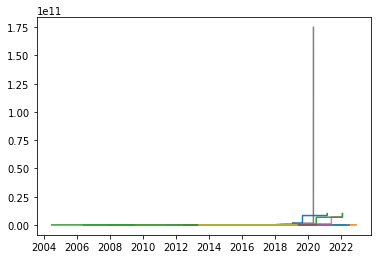

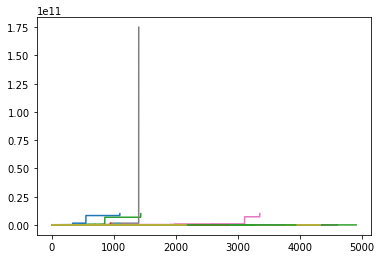

Normalize


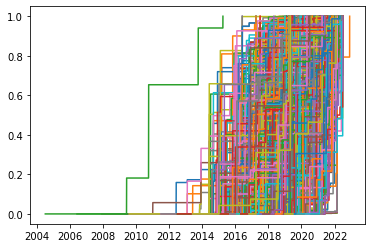

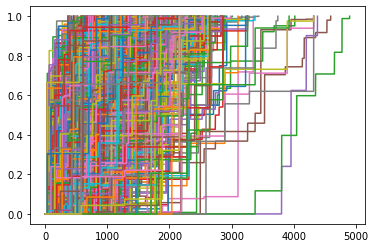

Compute yearly 'gradient'


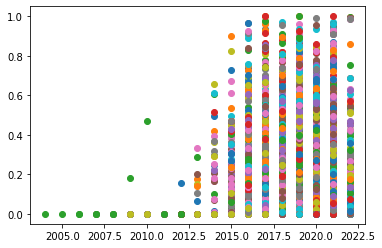

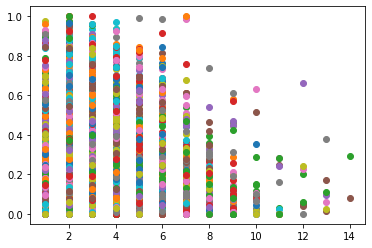

In [16]:
def plot_samples(samples_, scatter=False, year_x=False):
    plt.figure()
    for x in samples_:
        x_ = x.index if year_x else np.linspace(1,len(x),len(x))
        if scatter:
            plt.scatter(x_, x)
        else:
            plt.plot(x_, x)
    plt.show()
    
def apply(samples, f):
    samples_ = []
    for sample in samples:
        samples_.append(f(sample))
    return samples_

def select_bool(samples, mask):
    assert len(samples) == len(mask)
    samples_ = []
    for ix, sample in enumerate(samples):
        if ix:
            samples_.append(sample)
    return samples

def add_last_point(samples, year, month, day):
    if samples.index.max() < date(year, month, day):
        samples[datetime(year, month, day,0,0,0)] = samples.max()
    return samples
        
    
groups = list(df.groupby(["superclass", "task", "dataset", "metric"]))
samples = []
ds_labels = []
for ix, (grp, ds) in enumerate(groups):
    samples.append(ds.set_index("date")["result"])
    ds_labels.append((grp, ds))
    
"""
# Would add a fixed last point, we removed that
print("Adding last point")
samples = apply(samples, lambda x: add_last_point(x, 2020, 6, 1))
plot_samples(samples, year_x=True)
plot_samples(samples)
"""

print("Resample days (forward fill)")
samples = apply(samples, lambda x: x.groupby('date').mean().resample("D").ffill())
plot_samples(samples, year_x=True)
plot_samples(samples)
    
print("Normalize")
samples = apply(samples, lambda x: (x - x.min()) / (x.max() - x.min()))
plot_samples(samples, year_x=True)
plot_samples(samples)

print("Compute yearly 'gradient'")
grads = apply(samples, lambda x: x.groupby([x.index.year]).apply(lambda x: x.max() - x.min()))
plot_samples(grads, scatter=True, year_x=True)
plot_samples(grads, scatter=True)

In [5]:
import plotly.express as px
grad_df = pd.concat([grad.reset_index() for grad in grads], ignore_index=True)
fig = px.box(grad_df, x="date", y="result", points="all")
fig.write_image("artefacts/boxplot_difference.png", scale=2)
fig.show()

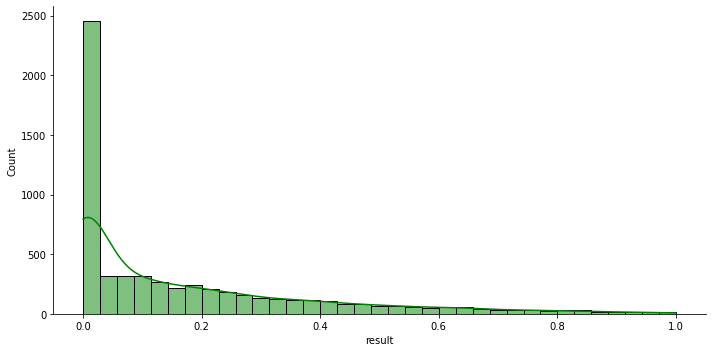

In [6]:
import seaborn as sns
sns.displot(grad_df["result"], color='g', kind="hist", kde=True, aspect=2)
# g.set_axis_labels(label_x, label_y)
# plt.savefig(f"artefacts/{prefix}_log.png")
plt.show()

# Clustering

## SOM

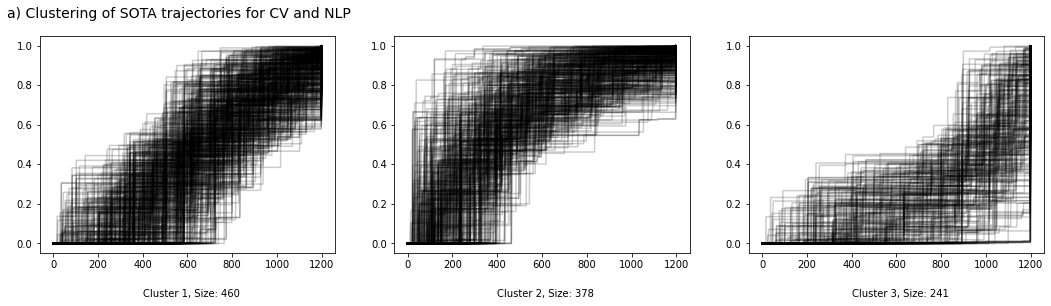

In [14]:
mySeries = []
for sample in samples:
    x = np.linspace(1, len(sample), len(sample))
    x_new = np.linspace(1, len(sample), 1200)
    mySeries.append(np.interp(x_new, x, sample))

som_x = 3
som_y = 1 # Define here the sub-figures

# Algorithms
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1, random_seed=10)


som.random_weights_init(mySeries)
som.train(mySeries, 50000)

cell_text = []
for series, label in zip(mySeries, ds_labels):
    winner = som.winner(series)
    cell_text.append([winner[0], label[0][0], label[0][2], label[0][1], label[0][3]])
dff = pd.DataFrame(cell_text, columns=["Cluster", "Superclass", "Benchmark", "Task", "Metric"])
dff.sort_values(by=["Cluster", "Superclass", "Benchmark"]).to_csv(f"artefacts/cluster_som.csv", index=None)

win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs
plt.figure(figsize=(18,4))
plt.gcf().suptitle("a) Clustering of SOTA trajectories for CV and NLP", fontsize=14, x=0.1, ha="left")
for ix_, class_ in enumerate([0,2,1]):
    class_ = (class_, 0)
    class__ = class_[0]
    plt.subplot(1, 3, ix_ + 1)
    for ix, xx in enumerate(win_map[class_]):
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.text(0.35, -0.2,f'Cluster {(ix_ + 1)}, Size: {(len(dff[dff["Cluster"] == (class__)]))}',
             transform=plt.gca().transAxes, alpha=1)
plt.savefig("artefacts/clustering_som.png", bbox_inches="tight")
plt.show()

## With dist from gold

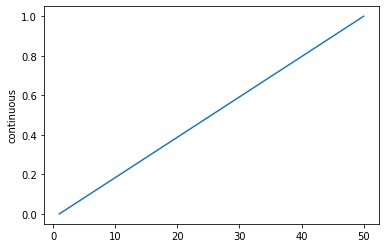

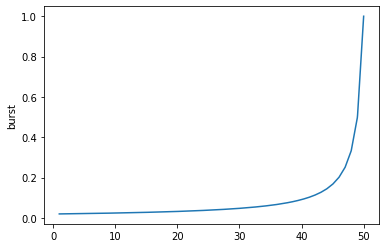

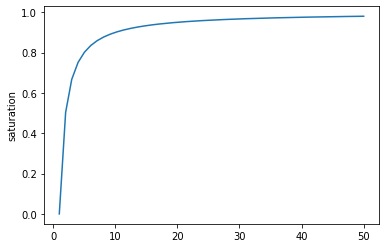

Init 1
0.000 --> 0.000 --> 
Init 2
0.000 --> 0.000 --> 


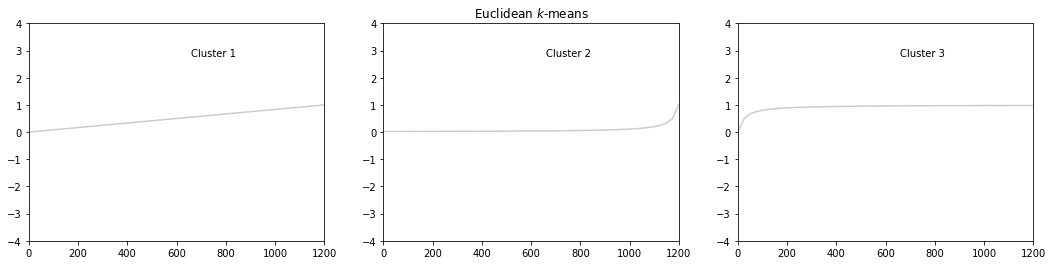

In [11]:
X = []
for sample in samples:
    x = np.linspace(1, len(sample), len(sample))
    x_new = np.linspace(1, len(sample), 1200)
    X.append(np.interp(x_new, x, sample))

X = to_time_series_dataset(X)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def get_gold(typ, num_sample, plot=False):
    x = np.linspace(1, 50, 50)
    x_new = np.linspace(1, 50, num_sample)
    if typ == "continuous":
        func = normalize(x) # f(x) = x
    elif typ == "burst":
        func = -1 / np.linspace(-50, -1, 50) # -1/x , x < 0
    elif typ == "saturation":
        func = -1 / np.linspace(1, 50, 50) + 1 # -1/x , x > 0
    func = np.interp(x_new, x, func)
        
    if plot:
        plt.plot(x_new, func)
        plt.ylabel(typ)
        plt.show()
    return func

# Params, please only even nums
num_sample = 1200

linear = get_gold("continuous", num_sample, True)
exp = get_gold("burst", num_sample, True)
log = get_gold("saturation", num_sample, True)
gold = to_time_series_dataset([exp, log, linear])

model = TimeSeriesKMeans(n_clusters=3, 
                         max_iter=10, 
                         random_state=42,
                         n_init=2,
                         verbose=True,
                         max_iter_barycenter=10)
gold_labels = model.fit_predict(gold)


plt.figure(figsize=(18,4))
for yi in range(3):
    plt.subplot(1, 3, yi + 1)
    for xx in gold[gold_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, 1200)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.show()

y_pred = model.predict(X)
y_trans = model.transform(X)

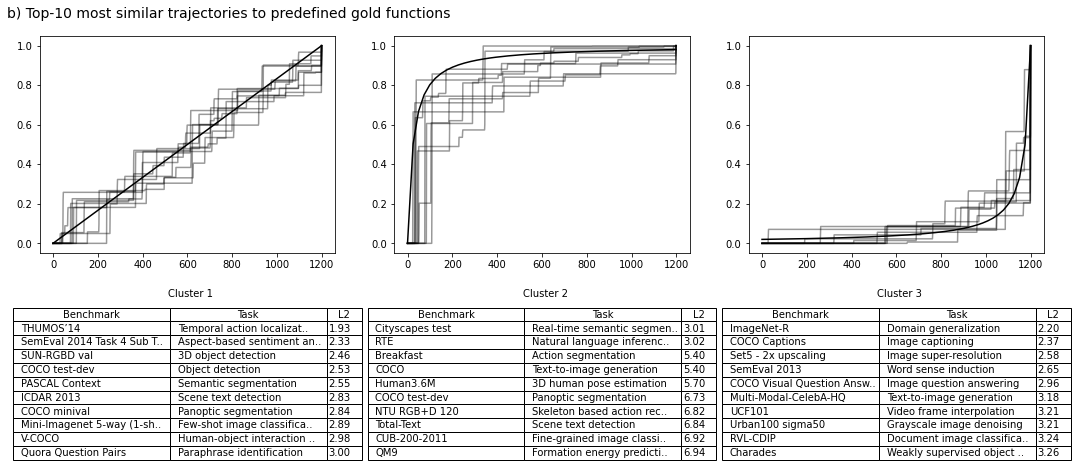

In [13]:
## Get top-k

class_ = 0


k = 10

plt.figure(figsize=(18,4))
plt.gcf().suptitle("b) Top-10 most similar trajectories to predefined gold functions", fontsize=14, x=0.1, ha="left")
for class_ in [0,1,2]:
    k_ = 0
    bmrks = set()
    cell_text = []
    
    ## changes positon and cluster label
    pos = 0 if class_ == 0 else 1 if class_ == 2 else 2
    
    plt.subplot(1, 3, pos + 1)
    args = np.argsort(y_trans, axis=0)
    plt.plot(gold[gold_labels == class_][0], "k-", alpha=1)
    plt.text(0.435, -0.2,'Cluster %d' % (pos + 1),
         transform=plt.gca().transAxes)
    
    for ix, xx in enumerate(args[:,class_]):
        benchmark_label = ds_labels[xx][0][1].replace("benchmarking", "")
        if benchmark_label not in bmrks:
            bmrks.add(benchmark_label)
            if k_ == k:
                break
            k_ += 1
            
            # print(ds_labels[xx][0][1])
            # plt.text(0, -0.275-0.05*ix,
            #          ds_labels[xx][0][1].replace("benchmarking", ""),
            #      transform=plt.gca().transAxes)
            cell_text.append([ds_labels[xx][0][2], ds_labels[xx][0][1], "%.2f" % y_trans[xx,class_]])
            cell_text[-1][0] =  (cell_text[-1][0][:25] + '..') if len(cell_text[-1][0]) > 25 else cell_text[-1][0]
            cell_text[-1][1] =  (cell_text[-1][1][:25] + '..') if len(cell_text[-1][1]) > 25 else cell_text[-1][1]
            plt.plot(X[xx].ravel(), "k-", alpha=.4)
    
        
    # dff = pd.DataFrame(cell_text, columns=["Benchmark", "Task", "L2"])
    # display(dff)
    # print('Cluster %d' % (class_ + 1))
    
    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
              colLabels=["Benchmark", "Task", "L2"],
              loc='bottom',
              colWidths=[0.45,0.45,0.1],
              cellLoc="left",
              bbox=[-0.09,-0.95,1.18,0.7]
             )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    
    cells = [key for key in the_table._cells]
    for cell in cells:
        the_table._cells[cell].PAD = 0.05
    # the_table.scale(1, 100)  # may help
        
        
plt.savefig("artefacts/top10_gold.png", bbox_inches="tight")
plt.show()